In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, LSTM, Dropout, Bidirectional, Dense, Embedding, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

import numpy as np

In [5]:
names = ['']

In [6]:
data = pd.read_csv('train.csv')

In [7]:
data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [8]:
# Extract all headers for visualization except text, comment_id and video_id
column_headers = data.columns.tolist()[2:]
print(column_headers)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [9]:
# Total of occurence of each labels
label_counts = data[column_headers].sum().sort_values()
print(label_counts)

threat             478
identity_hate     1405
severe_toxic      1595
insult            7877
obscene           8449
toxic            15294
dtype: int64


Text(0.5, 1.0, 'Distribution of Labels Occurence')

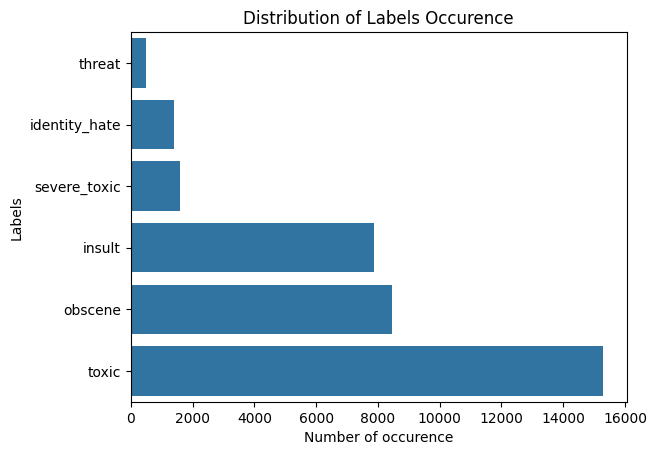

In [10]:
# Visualize the class distribution of the label column
ax = sns.barplot(x=label_counts.values,
                y=label_counts.index)

# Adding labels and title for the visualization
plt.xlabel('Number of occurence')
plt.ylabel('Labels')
plt.title('Distribution of Labels Occurence')

In [11]:
# Show the plot
plt.show()

In [12]:
# Create subsets of clean and toxic comments
toxic_comments = data[data[column_headers].sum(axis=1) > 0]
clean_comments = data[data[column_headers].sum(axis=1) == 0]

In [13]:
num_toxic_comments = len(toxic_comments)
num_clean_comments = len(clean_comments)

In [14]:
# Create DataFrame for visualization
plot_data = pd.DataFrame({
    'Category': ['Toxic', 'Clean'],
    'Count': [num_toxic_comments, num_clean_comments]
})

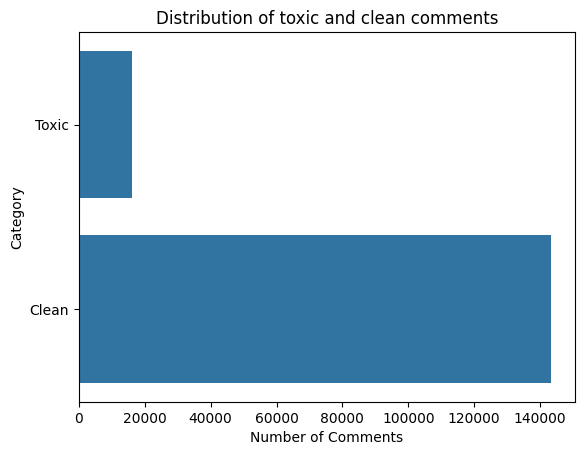

In [15]:
ax = sns.barplot(x='Count',y='Category', data=plot_data)

plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of toxic and clean comments')

plt.show()

In [16]:
# Handle dataset imbalance
train_clean_sample = clean_comments.sample(16225, random_state=42)
# Combine into one dataset
df = pd.concat([train_clean_sample, toxic_comments])
#Shuffle to avoid order bias
df = df.sample(frac=1, random_state=42)

In [17]:
comments = df['comment_text']

In [18]:
labels = df[df.columns[2:]]
labels

,toxic,severe_toxic,obscene,threat,insult,identity_hate
43242,0,0,0,0,0,0
44937,1,0,0,0,0,0
151831,0,0,0,0,0,0
128030,0,0,0,0,0,0
61287,0,0,0,0,0,0
...,...,...,...,...,...,...
133109,1,1,1,1,1,0
27165,0,0,0,0,0,0
97660,0,0,0,0,0,0
78629,0,0,0,0,0,0


In [1366]:
MAX_WORDS = 200000

In [1367]:
# INITILIZATION VECTORIZER TO ENCODE COMMENTS INTO INT
vectorizer = TextVectorization(max_tokens=MAX_WORDS, 
                           output_sequence_length=1800,
                           output_mode='int')

In [1368]:
# Encode text into int using vectorizer
vectorizer.adapt(comments.values)
vectorized_text = vectorizer(comments.values)

In [1369]:
vectorized_text

<tf.Tensor: shape=(32450, 1800), dtype=int64, numpy=
array([[   70,   101,     4, ...,     0,     0,     0],
       [   51,  1569, 11339, ...,     0,     0,     0],
       [  333,     6,    57, ...,     0,     0,     0],
       ...,
       [  325,   359,     7, ...,     0,     0,     0],
       [  813,    36,   520, ...,     0,     0,     0],
       [    5,  1403,   939, ...,     0,     0,     0]])>

In [1370]:
# Build data pipeline for model
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, labels))
dataset = dataset.cache()
dataset = dataset.shuffle(1000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(8)

In [1398]:
type(dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

1/1 [==============================] - 0s 37ms/step


In [1396]:
# Split data into train set, test set, validation set
train = dataset.take(int(len(dataset) * .7))
val = dataset.skip(int(len(dataset) * .7)).take(int(len(dataset) * .2))
test = dataset.skip(int(len(dataset) * .9)).take(int(len(dataset) * .1))

In [1372]:
model = Sequential()
# Create embedding layer 
model.add(Embedding(MAX_WORDS+1, 32))
# Birectional LSTM later
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor fully connected layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
# Final layer map to different output 
model.add(Dense(6, activation='sigmoid'))

In [1373]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy'])

In [1374]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, None, 32)          6400032   
                                                                 
 bidirectional_20 (Bidirect  (None, 64)                16640     
 ional)                                                          
                                                                 
 dense_72 (Dense)            (None, 128)               8320      
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_73 (Dense)            (None, 256)               33024     
                                                                 
 dropout_15 (Dropout)        (None, 256)               0         
                                                     

In [1375]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
709/710 [============================>.] - ETA: 0s - loss: 0.2559 - accuracy: 0.9648

2024-01-16 11:37:36.561330: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 187s 262ms/step - loss: 0.2559 - accuracy: 0.9648 - val_loss: 0.2002 - val_accuracy: 0.9729
Epoch 2/10


2024-01-16 11:37:45.997572: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


709/710 [============================>.] - ETA: 0s - loss: 0.1749 - accuracy: 0.9520

2024-01-16 11:40:43.674932: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 187s 263ms/step - loss: 0.1749 - accuracy: 0.9517 - val_loss: 0.1921 - val_accuracy: 0.8579
Epoch 3/10


2024-01-16 11:40:52.700422: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


709/710 [============================>.] - ETA: 0s - loss: 0.1473 - accuracy: 0.8646

2024-01-16 11:43:51.725313: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 188s 265ms/step - loss: 0.1476 - accuracy: 0.8646 - val_loss: 0.1912 - val_accuracy: 0.8143
Epoch 4/10


2024-01-16 11:44:00.763977: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


709/710 [============================>.] - ETA: 0s - loss: 0.1282 - accuracy: 0.8203

2024-01-16 11:47:11.288505: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 200s 282ms/step - loss: 0.1282 - accuracy: 0.8205 - val_loss: 0.1878 - val_accuracy: 0.8671
Epoch 5/10


2024-01-16 11:47:20.864903: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


709/710 [============================>.] - ETA: 0s - loss: 0.1145 - accuracy: 0.7908

2024-01-16 11:50:22.721519: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 191s 269ms/step - loss: 0.1146 - accuracy: 0.7910 - val_loss: 0.2025 - val_accuracy: 0.9042
Epoch 6/10


2024-01-16 11:50:32.011891: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


709/710 [============================>.] - ETA: 0s - loss: 0.1017 - accuracy: 0.8087

2024-01-16 11:53:35.179398: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 193s 271ms/step - loss: 0.1019 - accuracy: 0.8085 - val_loss: 0.2167 - val_accuracy: 0.7819
Epoch 7/10


2024-01-16 11:53:44.555992: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


709/710 [============================>.] - ETA: 0s - loss: 0.0907 - accuracy: 0.7489

2024-01-16 11:56:47.239535: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 192s 271ms/step - loss: 0.0907 - accuracy: 0.7489 - val_loss: 0.2212 - val_accuracy: 0.8080
Epoch 8/10


2024-01-16 11:56:56.729126: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


709/710 [============================>.] - ETA: 0s - loss: 0.0805 - accuracy: 0.7586

2024-01-16 11:59:59.621308: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 192s 271ms/step - loss: 0.0805 - accuracy: 0.7585 - val_loss: 0.2468 - val_accuracy: 0.7772
Epoch 9/10


2024-01-16 12:00:08.976378: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


709/710 [============================>.] - ETA: 0s - loss: 0.0701 - accuracy: 0.7617

2024-01-16 12:03:11.976813: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 193s 271ms/step - loss: 0.0701 - accuracy: 0.7619 - val_loss: 0.2477 - val_accuracy: 0.8673
Epoch 10/10


2024-01-16 12:03:21.544989: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


709/710 [============================>.] - ETA: 0s - loss: 0.0619 - accuracy: 0.7932

2024-01-16 12:06:25.939017: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


710/710 [==============================] - 194s 273ms/step - loss: 0.0619 - accuracy: 0.7930 - val_loss: 0.2684 - val_accuracy: 0.6626


2024-01-16 12:06:35.375427: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [1376]:
history.history

{'loss': [0.2558608651161194,
  0.1748611181974411,
  0.14757631719112396,
  0.12824967503547668,
  0.11457275599241257,
  0.10186082124710083,
  0.09073323011398315,
  0.08053339272737503,
  0.07007327675819397,
  0.06189288944005966],
 'accuracy': [0.9648327231407166,
  0.9516725540161133,
  0.8646126985549927,
  0.8205105662345886,
  0.7909771203994751,
  0.8084947466850281,
  0.7488996386528015,
  0.7585387229919434,
  0.7618837952613831,
  0.7930017709732056],
 'val_loss': [0.2002178281545639,
  0.19213542342185974,
  0.19121608138084412,
  0.18781819939613342,
  0.20250780880451202,
  0.21665357053279877,
  0.22120973467826843,
  0.24676606059074402,
  0.24765391647815704,
  0.2683762311935425],
 'val_accuracy': [0.9729064106941223,
  0.857912540435791,
  0.8143472671508789,
  0.8671489953994751,
  0.9042487740516663,
  0.7818657755851746,
  0.8080357313156128,
  0.7772475481033325,
  0.8673029541969299,
  0.6625615954399109]}

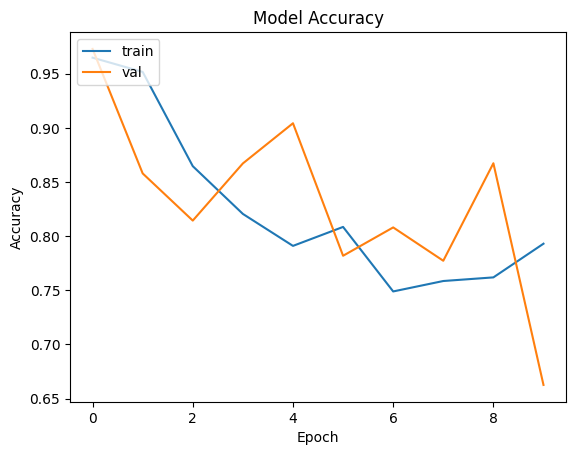

In [1377]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

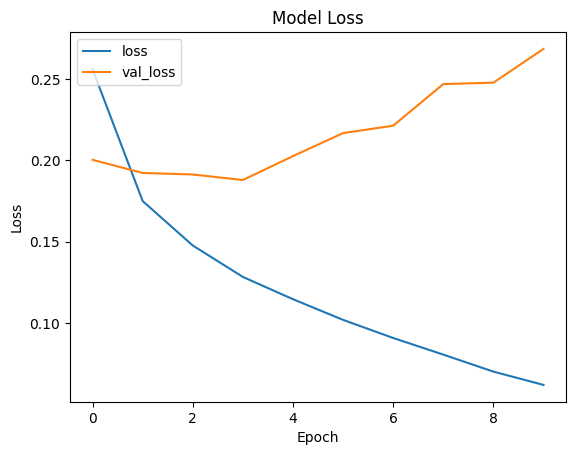

In [1378]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [1379]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 270ms/step


In [1380]:
batch_x, batch_y = test.as_numpy_iterator().next()

2024-01-16 12:06:36.034036: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [1381]:
(model.predict(batch_x) > .5).astype(int)

1/1 [==============================] - 0s 49ms/step


array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [1, 0, 1, 0, 1, 1],
       [1, 1, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [1382]:
def make_prediction(input_text):
    vectorized_text = vectorizer(input_text)
    return (model.predict(np.expand_dims(vectorized_text,0)) > 0.5).astype(int)

In [1383]:
batch_y

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 1],
       [1, 1, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [1384]:
make_prediction('you are suck')

1/1 [==============================] - 0s 26ms/step


array([[1, 0, 1, 0, 1, 0]])

In [1385]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [1386]:
for batch in test.as_numpy_iterator():
    # getting value x, y from batch
    x_true, y_true = batch

    # Making prediction from x_true
    predicted_y = model.predict(x_true)

    # Flatten prediction
    y_true = y_true.flatten()
    predicted_y = predicted_y.flatten()

    pre.update_state(y_true, predicted_y)
    re.update_state(y_true, predicted_y)
    acc.update_state(y_true, predicted_y)

1/1 [==============================] - 0s 49ms/step


In [1387]:
print(f'Precision: {pre.result()}, Accuracy: {acc.result()}, Recall: {re.result()}')

Precision: 0.7486018538475037, Accuracy: 0.0891089141368866, Recall: 0.7821369171142578


In [1388]:
!pip install gradio jinja2


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [1389]:
import gradio as gr 

In [1390]:
model.save('toxicity.keras')

In [1391]:
model = tf.keras.models.load_model('toxicity.keras')

In [1]:
def classify_message(input):
    vectorized_input = vectorizer(input)
    results = model.predict(np.expand_dims(vectorized_input,0))

    text = ''
    for index, col in enumerate(df.columns[2:]):
        text += f'{col}: {results[0][index] > 0.5} \n'
    return text

In [1394]:
interface = gr.Interface(fn = classify_message, 
                        inputs = gr.Textbox(lines=2, placeholder='Enter you message here...'),
                        outputs = 'text')

In [1395]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7868
Running on public URL: https://6de2d6bc7d9ec457d2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 39ms/step
